# Part I: Supervised Learining 

In [13]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt 
import scipy
import scipy.io as spio
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import math
import urllib
from urllib.request import urlopen
%matplotlib inline
import urllib.request

In [14]:
#Extract data as an array from the url
link = "http://www0.cs.ucl.ac.uk/staff/M.Herbster/SL/misc/zipcombo.dat"
filename = 'zipcombo.dat'
urllib.request.urlretrieve(link, filename)
data = np.loadtxt(filename)     # read numpy array from file

In [16]:
data.shape

(9298, 257)

## Multiclass Perceptron with Polynomial Kernel

In [18]:
y = data[:,0]
x = data[:,1:]

In [186]:
data.shape

(9298, 257)

In [189]:
#Not sure if I should include bias before computing the Kernel? 
def add_bias(x):
    x_with_bias = np.ones((x.shape[0],x.shape[1]+1))
    x_with_bias[:,:-1] = x
    return x_with_bias

def Polynomial_Kernel(x1,x2,d):
    K = (x1 @ x2.T)**d
    return K

def transform_y(y):
    #classes_num = len(y.unique())
    #assuming that training set has all the numbers between min(y) and max(y)
    classes_num = 10
    m = len(y)
    y_matrix = np.ones((m,classes_num))*(-1)
    for i in range(m):
        y_matrix[i,int(y[i])] = 1
    return y_matrix

In [190]:
def perceptron_train(x,y,d=2):
    m = x.shape[0] #number of examples
    n = x.shape[1] #number of features
    classes_num = 10 #number of classes 
    
    errors = np.zeros(m)
    y_arr = transform_y(y) 
    alpha = np.zeros((m,classes_num)) #Need to store alpha array at all iteration, as we need it to compute confidence
    K_train = Polynomial_Kernel(x,x,d)
    
    num_errors = 0 #This should be bounded..? Maybe calculate the bound in the explanation
    W = np.zeros((m,classes_num)) #with bias?
    
    #iterate through training set
    for t in range(m):
        if t<1:
            alpha_prev = np.zeros((1,classes_num)) #when t=0, the previous alpha is set to be 0
        else:
            alpha_prev = alpha[t-1,:] #
        
        #find our training set
        x_t = x[t,:] #of size (1,n)
        y_t = y[t]
        y_arr_t = y_arr[t,:] #of size (1,10) 
        
        #pred_t computes \sum^{t-1}_{i=0} {(alpha_i K(x_t, x_i))}, which is regarded as the confidence in each class
        pred_t = ((alpha[:t,:].T @K_train[t,:t]).T) 
        y_hat_t = np.where(pred_t==max(pred_t),1,0) #map the confidence to arrays of 1 and 0 for class
        gamma_t = y_arr_t.T @ pred_t
        
        if t%100==0:
            
            print('t=',t)
            print('label=', y_t)
            print('alpha_t-1',alpha[:t,:])
            print('predicted label=',pred_t.argmax())
            print('prediction=',pred_t)
            print('gamma_t=',gamma_t)

        #if gamma_t < 0.01:
        if pred_t.argmax()!=y_t:
            #print('misclassification:',gamma_t)
            #update the alpha, and weights, for all the classes that not the true class
            num_errors +=1
            
            #since we only want to update the weights related to first t-1 training data.
            #note that alpha_t is np.zeros(10,1), 
            #and alpha_t is updated according to the real class, and the misclassified class. 
            alpha_t = alpha_prev + np.where(y_arr_t> 0,1,0) + np.where(y_hat_t>0,-1,0) #(1,10)
            
            #store alpha_t into the matrix for future reference
            alpha[t,:] = alpha_t
            
            #sandwich K(x_t, x_i) for i in [1,t-1] in a zeros array of size(m). 
            #reason being weight for one class is of size(m), but we only 'have enough data' to update the first t-1 terms.  
            K_update = np.zeros((1,m))
            K_update[:,:t] = K_train[t,:t] 
            
            #Note that W is a weight matrix of size (m, 10)
            #K_update.T @alpha_t is the update for weight matrix, for every class and every training set that has been reviewed. 
            W = W+ K_update.T @(alpha_t.reshape(1,10)) #(1, 10) * (1,m), want (m,10)
        else:
            W = W #no change
            
        errors[t] = num_errors         
    return W,errors

In [182]:
#Test this function, see if it is working properly
W,errors = perceptron_train(x,y,d=2)

t= 0
label= 6.0
alpha_t-1 []
predicted label= 0
prediction= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
gamma_t= 0.0
t= 100
label= 8.0
alpha_t-1 [[-1. -1. -1. -1. -1. -1.  0. -1. -1. -1.]
 [-1. -1. -1. -1. -1.  0. -1. -1. -1. -1.]
 [-1. -1. -1. -1.  0.  0. -2. -1. -1. -1.]
 [-1. -1. -1. -1.  0. -1. -2.  0. -1. -1.]
 [-1. -1. -1.  0.  0. -2. -2.  0. -1. -1.]
 [-1. -1. -1.  0. -1. -2. -1.  0. -1. -1.]
 [-1. -1. -1.  1. -1. -2. -1. -1. -1. -1.]
 [-1.  0. -1.  0. -1. -2. -1. -1. -1. -1.]
 [ 0.  0. -1. -1. -1. -2. -1. -1. -1. -1.]
 [ 0.  1. -1. -2. -1. -2. -1. -1. -1. -1.]
 [ 0.  0. -1. -2. -1. -2. -1.  0. -1. -1.]
 [ 1.  0. -1. -2. -1. -2. -1. -1. -1. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  1.  0.  0.  0.  0.  0.]
 [-1. -1.  0.  0.  1.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -

t= 1900
label= 5.0
alpha_t-1 [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
predicted label= 5
prediction= [ -89543.24947568 -128160.0231042  -112711.7418766   -64603.98021173
 -145832.83487954  -53008.80670149  -81788.41553748 -195273.82544041
 -109941.17117053 -151383.6750802 ]
gamma_t= 1026230.1100748755
t= 2000
label= 0.0
alpha_t-1 [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
predicted label= 0
prediction= [ -26946.26897345 -104912.45969689  -80305.86044335  -98143.66490234
 -102172.85026434  -97269.95639646  -95806.85528665  -71646.24261237
 -101311.34663307 -116825.83185203]
gamma_t= 841448.7991140406
t= 2100
label= 7.0
alpha_t-1 [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [

t= 5300
label= 9.0
alpha_t-1 [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
predicted label= 9
prediction= [-188855.5346679  -234443.95841182 -190167.3234956  -151695.09601627
  -77590.50591536 -207712.88495156 -204007.42009817 -119224.66850653
 -142191.68321067  -51730.7651947 ]
gamma_t= 1464158.3100791802
t= 5400
label= 1.0
alpha_t-1 [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
predicted label= 1
prediction= [-190403.85706377  -23332.90381189 -174598.07535718 -236151.46335443
 -137000.87396497 -170144.8413071  -176089.14143955 -182798.44522106
 -156244.38788418 -208524.34387047]
gamma_t= 1608622.5256508305
t= 5500
label= 4.0
alpha_t-1 [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 

  -22861.25686754  -56544.49061589]
gamma_t= 566179.5953248712
t= 7200
label= 3.0
alpha_t-1 [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
predicted label= 3
prediction= [ -77323.02461763  -60474.38233955  -34727.51970687   26067.9111181
  -69110.32962244  -35038.22328056  -49033.35275869  -54533.14656179
  -73661.02962865 -110885.33085121]
gamma_t= 590854.2504854923
t= 7300
label= 9.0
alpha_t-1 [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
predicted label= 9
prediction= [-165896.92313007 -248369.89835384 -157558.14186542 -180907.45558732
 -110287.48888338 -189884.57527685 -163564.16540173 -119035.42797251
 -134398.64096542  -20902.36594069]
gamma_t= 1449000.3514958597
t= 7400
label= 4.0
alpha_t-1 [[

In [184]:
#Plot number of misclassfication versus the number of training sets reviewed. 
ratio = errors/np.arange(1,x.shape[0]+1)

Text(0.5, 1.0, 'Proportion of misclassified data points out of data points reviewed')

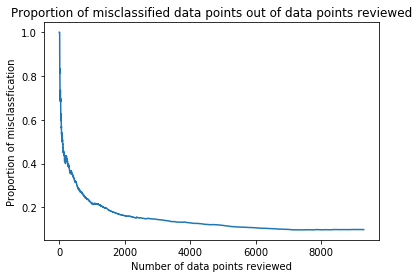

In [185]:
plt.plot(ratio)
plt.ylabel('Proportion of misclassfication')
plt.xlabel('Number of data points reviewed')
plt.title('Proportion of misclassified data points out of data points reviewed')

# Q1 - Basic Results

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import pandas as pd

def allocate_training_test_sets(data,r =1/5):
    X= data[:,0:-1]
    y= data[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=r)
    return X_train, X_test, y_train, y_test

In [ ]:
def perceptron_test(x_test,x_train,y_test,W,d):
    m = x_test.shape[0] #number of examples
    n = x_test.shape[1] #number of features
    classes_num = 10 #number of classes 
    
    ### I still need to find out how this thing is tested. 

In [ ]:
X_train, X_test, y_train, y_test = allocate_training_test_sets(data,r =1/5)
d_arr = np.arange(1,8)
for i in d_arr:
    W,train_errors = perceptron_train(X_train,y_train,d_arr[i])
    test_error = perceptron_test(X_test,X_train, y_test,W,d_arr[i])